# Gradient Descent Construction

In [ ]:
%pip install -q --progress-bar off d2l==1.0.0a1.post0 # replace ! with % for jupyter notebook

Ref: https://d2l.ai/chapter_optimization/gd.html

In [90]:
from abc import ABC, abstractmethod, ABCMeta
from typing import Optional, Tuple, List, Callable

# import numpy as np
from d2l import torch as d2l
import torch
import copy

import autograd.numpy as np  # Thinly-wrapped numpy
from autograd import grad    # The only autograd function you may ever need

In [6]:
class Function:
    def __init__(self, f: Callable):
        self._f = f

    def __call__(self, x, *args, **kwargs) -> float:
        # a function returns a scalar float
        fx = self._f(*args, **kwargs)
        return fx


class GradFunction:
    def __init__(self, grad_f: Callable):
        self._grad_f = grad_f

    def __call__(self, x, *args, **kwargs) -> np.ndarray:
        # grad fn/vector returns an array of vector
        grad_fx = self._grad_f(*args, **kwargs)
        return grad_fx

In [91]:
class Optimizer(metaclass=ABCMeta):
    """Abstract class for optimizers."""

    def __init__(
        self, f: Callable, grad_f: Callable, num_epochs: int, lr: float
    ):
        self._f = f
        self._grad_f = grad_f
        self._num_epochs = num_epochs
        self._lr = lr

    @abstractmethod
    def update(
        self,
        weights: np.ndarray,
        biases: Optional[np.ndarray],
    ) -> None:
        """Update the weights and biases.

        Args:
            weights (np.ndarray): 
            biases (np.ndarray): 


        Raises:
            NotImplementedError: 
        """

        raise NotImplementedError


class GradientDescent(Optimizer):
    def __init__(
        self, f: Callable, grad_f: Callable, num_epochs: int, lr: float
    ):
        self._f = f
        self._grad_f = grad_f
        self._num_epochs = num_epochs
        self._lr = lr
        self.weights_history = []
  
    def update(
        self,
        weights: np.ndarray,
        biases: Optional[np.ndarray] = None,
    ) -> None:

        for epoch in range(1, self._num_epochs + 1):

            # grad vec at each point 
            gradient_vector = self._grad_f(weights)
            weights -= self._lr * gradient_vector
        
            if biases is not None:
                pass # implement next time
                # biases -= self._lr * gradient_vector[1:]

            print(f"Epoch {epoch}: weights {weights}, biases {biases}")

            # must use copy if not weights (np array) mutatable: https://tinyurl.com/bdff69by
            self.weights_history.append(copy.copy(weights)) 
      
        return weights, biases, self.weights_history

In [92]:
def f(w):  # Objective function
    return w ** 2


def grad_f(
    w,
):  # Gradient (derivative) of the objective function
    return 2 * w

In [93]:
batch_gd = GradientDescent(f=f, grad_f = grad_f, num_epochs=10, lr=0.2)

In [94]:
initial_weight = 10
initial_bias = None # we ignore bias for simplicity
_, _, weights_history = batch_gd.update(initial_weight)

Epoch 1: weights 6.0, biases None
Epoch 2: weights 3.5999999999999996, biases None
Epoch 3: weights 2.1599999999999997, biases None
Epoch 4: weights 1.2959999999999998, biases None
Epoch 5: weights 0.7775999999999998, biases None
Epoch 6: weights 0.46655999999999986, biases None
Epoch 7: weights 0.2799359999999999, biases None
Epoch 8: weights 0.16796159999999993, biases None
Epoch 9: weights 0.10077695999999996, biases None
Epoch 10: weights 0.06046617599999997, biases None


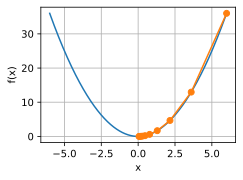

In [95]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

show_trace(weights_history, f)

## 2D Example

Let the problem be a linear model involving 2 variables:

$$
y = X \beta = \beta_1 x_1 + \beta_2 x_2 
$$

As usual, we know $X$ is the design matrix and we want to find optimal weights for $\beta$.

Later we will use $\beta$ and $w$ interchangeably.

Let the loss function be 

$$
L(\beta_1, \beta_2) = \beta_1^2 + 2\beta_2^2
$$

Then its gradient vector at a point $(\beta_1, \beta_2)$ is:

$$
\nabla L(\beta_1, \beta_2) = \begin{bmatrix} 2\beta_1 \\ 4\beta_2 \end{bmatrix}
$$

In [96]:
def f_2d(w1, w2):  # Objective function
    return w1 ** 2 + 2 * w2 ** 2

def grad_f_2d(w1, w2):  # Gradient of the objective function
    return (2 * w1, 4 * w2)

We reframe the same functions below to take in only 1 weight vector so autograd can do its work.

In [97]:
def f_2d(w):  # Objective function
    w1, w2 = w[0], w[1]
    return w1 ** 2 + 2 * w2 ** 2
    
def grad_f_2d(w):  # Gradient of the objective function
    return np.asarray([2 * w[0], 4 * w[1]])

In [98]:
initial_weights = np.asarray([-5, -2]).astype('float32') # x1, x2, s1, s2 = -5, -2, 0, 0
initial_biases = None # we ignore bias for simplicity

We can use autograd to directly compute the gradient vector for us.

In [99]:
autograd_f = grad(f_2d)
autograd_f(initial_weights)

array([-10.,  -8.], dtype=float32)

In [100]:
# batch_gd = GradientDescent(f=f_2d, grad_f = grad_f_2d, num_epochs=20, lr=0.1)

In [101]:
batch_gd = GradientDescent(f=f_2d, grad_f = autograd_f, num_epochs=20, lr=0.1) # autograd

In [102]:
_, _, weights_history = batch_gd.update(initial_weights)

Epoch 1: weights [-4.  -1.2], biases None
Epoch 2: weights [-3.2  -0.72], biases None
Epoch 3: weights [-2.56  -0.432], biases None
Epoch 4: weights [-2.0479999 -0.2592   ], biases None
Epoch 5: weights [-1.6383998  -0.15551999], biases None
Epoch 6: weights [-1.3107198 -0.093312 ], biases None
Epoch 7: weights [-1.0485759 -0.0559872], biases None
Epoch 8: weights [-0.8388607  -0.03359232], biases None
Epoch 9: weights [-0.6710886  -0.02015539], biases None
Epoch 10: weights [-0.53687084 -0.01209324], biases None
Epoch 11: weights [-0.42949668 -0.00725594], biases None
Epoch 12: weights [-0.34359735 -0.00435356], biases None
Epoch 13: weights [-0.27487788 -0.00261214], biases None
Epoch 14: weights [-0.2199023  -0.00156728], biases None
Epoch 15: weights [-0.17592184 -0.00094037], biases None
Epoch 16: weights [-0.14073747 -0.00056422], biases None
Epoch 17: weights [-0.11258998 -0.00033853], biases None
Epoch 18: weights [-0.09007198 -0.00020312], biases None
Epoch 19: weights [-0.072

In [103]:
def show_trace_2d(f, results): 
    """Show the trace of 2D variables during optimization."""
    d2l.set_figsize()
    d2l.plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                          torch.arange(-3.0, 1.0, 0.1))
    d2l.plt.contour(x1, x2, f([x1, x2]), colors='#1f77b4')
    d2l.plt.xlabel('x1')
    d2l.plt.ylabel('x2')

In [104]:
weights_history

[array([-4. , -1.2], dtype=float32),
 array([-3.2 , -0.72], dtype=float32),
 array([-2.56 , -0.432], dtype=float32),
 array([-2.0479999, -0.2592   ], dtype=float32),
 array([-1.6383998 , -0.15551999], dtype=float32),
 array([-1.3107198, -0.093312 ], dtype=float32),
 array([-1.0485759, -0.0559872], dtype=float32),
 array([-0.8388607 , -0.03359232], dtype=float32),
 array([-0.6710886 , -0.02015539], dtype=float32),
 array([-0.53687084, -0.01209324], dtype=float32),
 array([-0.42949668, -0.00725594], dtype=float32),
 array([-0.34359735, -0.00435356], dtype=float32),
 array([-0.27487788, -0.00261214], dtype=float32),
 array([-0.2199023 , -0.00156728], dtype=float32),
 array([-0.17592184, -0.00094037], dtype=float32),
 array([-0.14073747, -0.00056422], dtype=float32),
 array([-0.11258998, -0.00033853], dtype=float32),
 array([-0.09007198, -0.00020312], dtype=float32),
 array([-0.07205759, -0.00012187], dtype=float32),
 array([-5.7646073e-02, -7.3123156e-05], dtype=float32)]

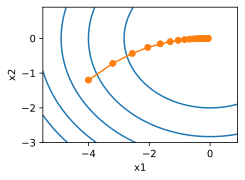

In [105]:
show_trace_2d(f_2d, weights_history)